## Experiment Workflow Notebook v1

#### Sources of information, code and discussions

1. This notebook follows the 5 step process presented in the Chris Deotte "How to compete with GPUs Workshop" [here][1].
2. Triple stratified KFold TFRecords used for image data is explained [here][2].
3. Some code sections have been reused from AgentAuers' notebook [here][3]
4. The advantage of using different input sizes is discussed [here][4]
5. Use external data by changing the variables `INC2019` and `INC2018`.These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][5]

[1]: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
[3]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[4]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147
[5]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

#### Train Experiments
In this notebook we run 6 experiments.
* Experiment 1 - baseline - no upsample or dropout but with class balance and 2018 data
* Experiment 2 - upsample 2018 malignant (ie double 2018 compared to 2020)
* Experiment 3 - upsample 2020 and 2018 malignant
* Experiment 4 - upsample all
* Experiment 5 - add minor dropout
* Experiment 6 - add major dropout

This note book will repeatedly run experiments on the same KFold fold. Each experiment will be trained for the number of EPOCHS you chose in the configuration above. Each experiment the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

####  Initiatialise environment and import necessary libraries

In [1]:
# Use if running in Kaggle environment
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# import KaggleDatasets if running in Kaggle environment
from kaggle_datasets import KaggleDatasets

import os, re, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score 
from sklearn.utils import class_weight

## Configuration

* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 for conistent number of train and validation samples across folds
* IMG_SIZES - These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter. Consider early stopping in Callbacks.
* EFF_NETS - These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

### New Variables
* EXPERIMENTS - number of experiments to perform
* FNUMBER - which of the KFolds to repeatedly perform experiments on. 
* M1 - is a list of length EXPERIMENTS. For each experiment, choose 0, 1, 2, 3, etc. Determines how many additional copies of malignant images from this years comp data to add
* M2 - is a list. Adds copies of malignant images from ISIC archive that are not in 2020, 2019, 2018, 2017 comp data
* M3 - is a list. Adds copies of malignant images from 2019 comp data. They have been filtered to include the ones that look like 2020 data
* M4 - is a list. Adds copies of malignant images from 2018 2017 data.
* DROP_FREQ - a list of floats between 0 and 1. Determines proportion of train images to apply coarse dropout to
* DROP_CT - a list of ints. How many squares to remove from train images when applying dropout. (Note that if you use CT>16 with FREQ=1, it may slow down training when using small image resolutions like 128x128 if your CPU is slow).
* DROP_SIZE - a list of floats between 0 and 1. The size of square side equals `IMG_SIZE * DROP_SIZE`
* INFER_TEST - whether to predict test images each experiment

Image sizes used in the Efficientnet model:

- efficientnet-b0-224 -cv train with 192
- efficientnet-b1-240 -cv train with 256
- efficientnet-b2-260 -cv train with 256
- efficientnet-b3-300 -cv train with 384
- efficientnet-b4-380 -cv train with 384
- efficientnet-b5-456 -cv train with 512
- efficientnet-b6-528 -cv train with 512
- efficientnet-b7-600 -cv train with 768

Better to train with a larger size and let the model scale down rather than up.

In [3]:
ENV = "KAGGLE" #or "LOCAL"

# DEFAULT TO TPU TO ENSURE KAGGLE TPU COMPATIABILITY
# https://www.kaggle.com/docs/tpu
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 45

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH FOLD SET TO PERFORM EXPERIMENTS ON
FNUMBER = 5; EXPERIMENTS = 5

# UPSAMPLE MALIGNANT COUNT TIMES
M1 = [0,1,1,1,1] #2020 malig
M2 = [0,0,1,1,1] #ISIC malig
M3 = [0,0,1,1,1] #2019 good malig
M4 = [0,1,1,1,1] #2018 2017 malig

# COARSE DROPOUT
DROP_FREQ = [0,0,0,0.5,0.75] # between 0 and 1
DROP_CT = [0,0,0,4,8] # may slow training if CT>16
DROP_SIZE = [0,0,0,0.1,0.2] # between 0 and 1

print("Check:", (len(M1)+len(M2)+len(M3)+len(M4)+len(DROP_FREQ)+len(DROP_CT)+len(DROP_SIZE))/7/EXPERIMENTS)

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [128]*EXPERIMENTS

# META DATA? YES=1 NO=0
META = 1

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0]*EXPERIMENTS
INC2018 = [1]*EXPERIMENTS

# BATCH SIZE AND EPOCHS
# TRY 8, 16, 32, 64, 128, 256. REDUCE IF OOM ERROR, HIGHER FOR TPUS
BATCH_SIZES = [128]*EXPERIMENTS
EPOCHS = [20]*EXPERIMENTS
EARLY_STOPPING = 0 # Yes:1, No:0

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [0]*EXPERIMENTS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/EXPERIMENTS]*EXPERIMENTS

# TEST TIME AUGMENTATION STEPS
TTA = 25

Check: 1.0


#### Configure environment to use TPUs, Multiple GPUs, Single GPU or just CPU

In [4]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


### Step 1: Preprocess and file handling
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section.

In [5]:
# Load file locations
if ENV == 'KAGGLE':
    #Use GCS if running in Kaggle environment
    PATH = [None]*EXPERIMENTS; PATH2 = [None]*EXPERIMENTS; PATH3 = [None]*EXPERIMENTS
    for i,k in enumerate(IMG_SIZES[:EXPERIMENTS]):
        PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
        PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
        PATH3[i] = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i'%(k,k))
    files_train = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/test*.tfrec')))
       
if ENV == 'LOCAL':  
    # Use LDS if running in local environment
    PATH = [None]*EXPERIMENTS; PATH2 = [None]*EXPERIMENTS; PATH3 = [None]*EXPERIMENTS
    for i,k in enumerate(IMG_SIZES[:EXPERIMENTS]):
        PATH[i] = f"./siim-isic-melanoma-classification/tfrecords{k}"
        PATH2[i] = f"./siim-isic-melanoma-classification/tfrecords{k}Ext"
        PATH3[i] = f"./siim-isic-melanoma-classification/tfrecords{k}Mal"
    files_train = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/test*.tfrec')))  

In [6]:
# Save file locations
if ENV == 'KAGGLE':
    LOG_PATH = ''
    CV_OOF_PREDS_PATH = ''
    CV_TEST_PREDS_PATH = ''
    CV_FOLDS_PATH = ''

if ENV == 'LOCAL':
    LOG_PATH = './logs/'
    CV_OOF_PREDS_PATH = './cv_oof_preds/'
    CV_TEST_PREDS_PATH = './cv_test_preds/'
    CV_FOLDS_PATH = './cv_folds/'

In [7]:
# File handling functions
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_meta_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image_name'], example['sex'], example['age_approx'], example['anatom_site_general_challenge'], example['target']

def read_meta_tfrecord_test(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image_name'], example['sex'], example['age_approx'], example['anatom_site_general_challenge']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
# Function to stream datasets into model when training, validating and predicting
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256,
                droprate=0, dropct=0, dropsize=0):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim,
                                               droprate=droprate, dropct=dropct, dropsize=dropsize),
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [9]:
# Function to stream datasets into model when training, validating and predicting
column_names = ['image_name', 'sex', 'age_approx', 'anatom', 'target']
column_names_test = ['image_name', 'sex', 'age_approx', 'anatom']

def get_meta(files, batch_size=16, test=0):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    if test:
        ds = ds.map(lambda example: read_meta_tfrecord_test(example), num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_meta_tfrecord(example), num_parallel_calls=AUTO)      
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
        
    return ds

def meta_unbatch(files, test=0):
    if test:
        meta_np = np.array([[img_name.numpy().decode("utf-8"),
                  sex.numpy(),
                  age.numpy(),
                  anatomy.numpy()]
                for img_name, sex, age, anatomy in iter(files.unbatch())])
        meta_df = pd.DataFrame(data = meta_np, columns=column_names_test)

    else:        
        meta_np = np.array([[img_name.numpy().decode("utf-8"),
                  sex.numpy(),
                  age.numpy(),
                  anatomy.numpy(),
                  target.numpy()] 
                for img_name, sex, age, anatomy, target in iter(files.unbatch())])
        
        meta_df = pd.DataFrame(data = meta_np, columns=column_names)
        meta_df = meta_df.astype({"target": int})
    return meta_df

### Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation. This notebook also uses horizontal flip, saturation, contrast, brightness augmentation similar to last years winner.

In [10]:
# Assign variables
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [11]:
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

def prepare_image(img, augment=True, dim=256, droprate=0, dropct=0, dropsize=0):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM=dim, PROBABILITY=droprate, CT=dropct, SZ=dropsize)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

### Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN. Also consider different models to provide diversity of predictions which may benefit the final ensemble.

In [13]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=128, ef=0, v=0):
    inputs = tf.keras.layers.Input(shape=(dim,dim,3))
    
    base = EFNS[ef](input_shape=(dim,dim,3),weights='noisy-student',include_top=False)
    
    x = base(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    
    if v:
        model.summary()
    
    return model

# Visualise model in use
build_model(dim=IMG_SIZES[0],ef=EFF_NETS[0],v=1)

16703488/16696600 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


In [14]:
# META DATA FUNCTION

# Function to get meta data
def meta_model(meta_train, meta_val):
    L = 15
    feat = ['sex','age_approx','anatom']
    M = meta_train.target.mean()
    te = meta_train.groupby(feat)['target'].agg(['mean','count']).reset_index()
    te['ll'] = ((te['mean']*te['count'])+(M*L))/(te['count']+L)
    del te['mean'], te['count']
    meta_val = meta_val.merge( te, on=feat, how='left' )
    meta_val['ll'] = meta_val['ll'].fillna(M)
    return meta_val


### Step 4: Training and Cross Validation

#### Training Schedule
Thism is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [15]:
TS_CFG = dict(
    lr_start   = 0.000005, 
    lr_max     = 0.00000125 * REPLICAS * BATCH_SIZES[0],
    lr_min     = 0.000001,
    lr_ramp_ep = 5,
    lr_sus_ep  = 0,
    lr_decay   = 0.7
    )

In [16]:
def get_lr_callback(ts_cfg, batch_size=8):
    lr_start   = ts_cfg['lr_start']
    lr_max     = ts_cfg['lr_max']
    lr_min     = ts_cfg['lr_min']
    lr_ramp_ep = ts_cfg['lr_ramp_ep']
    lr_sus_ep  = ts_cfg['lr_sus_ep']
    lr_decay   = ts_cfg['lr_decay']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    
    return lr_callback

#### Visualise Training Schedule

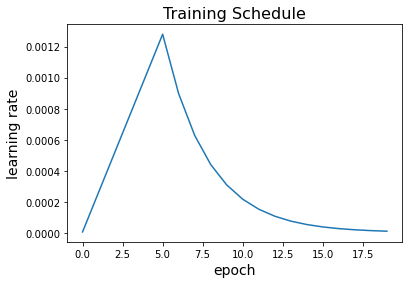

In [17]:
# Quick test and visualisation of learning rate schedule
# Important not to have a high learning rate which would destroy the pre-trained parameters
lr_start   = TS_CFG['lr_start']
lr_max     = TS_CFG['lr_max']
lr_min     = TS_CFG['lr_min']
lr_ramp_ep = TS_CFG['lr_ramp_ep']
lr_sus_ep  = TS_CFG['lr_sus_ep']
lr_decay   = TS_CFG['lr_decay']

def lrfn_sched(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

# Visualise learning rate schedule
rng = [i for i in range(20)]
y = [lrfn_sched(x) for x in rng]
plt.plot(rng, y)
plt.xlabel('epoch', size=14); plt.ylabel('learning rate', size=14)
plt.title('Training Schedule', size=16); plt.show()

#### Class Imbalance Analysis

In [18]:
# Analyze class imbalance in the targets
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / (33126-470))*(33126)/2.0 
weight_for_1 = (1 / 470)*(33126)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 35.24


#### Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [19]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    if fold==(FNUMBER-1):
        idxTT = idxT; idxVV = idxV
        print('### Using fold',fold,'for experiments')
    print('Fold',fold,'has TRAIN:',idxT,'VALID:',idxV)

Fold 0 has TRAIN: [ 0  1  2  3  4  5  7 10 11 12 13 14] VALID: [6 8 9]
Fold 1 has TRAIN: [ 0  1  3  4  5  6  8  9 11 12 13 14] VALID: [ 2  7 10]
Fold 2 has TRAIN: [ 0  2  3  5  6  7  8  9 10 11 12 13] VALID: [ 1  4 14]
Fold 3 has TRAIN: [ 1  2  3  4  6  7  8  9 10 11 12 14] VALID: [ 0  5 13]
### Using fold 4 for experiments
Fold 4 has TRAIN: [ 0  1  2  4  5  6  7  8  9 10 13 14] VALID: [ 3 11 12]


#########################
#### EXPERIMENT 1
#########################
#### Using the following TFRecords:
[ 0  1  2  4  5  6  7  8  9 10 13 14] [ 3 11 12]
#### Image Size 128 with EfficientNet B0 and batch_size 1024
#### DropoutFreq 0 Count0 Size 0
#### Using 2018+2017 external data
#########################
Weight for class 0: 0.53
Weight for class 1: 10.21
Training...
Epoch 1/20
35/35 [==============================] - ETA: 0s - auc: 0.5029 - loss: 0.7249
Epoch 00001: val_loss improved from inf to 0.64997, saving model to EB0-128-fold-0-EXP.h5
35/35 [==============================] - 19s 544ms/step - auc: 0.5029 - loss: 0.7249 - val_auc: 0.4854 - val_loss: 0.6500 - lr: 5.0000e-06
Epoch 2/20
35/35 [==============================] - ETA: 0s - auc: 0.8336 - loss: 0.5304
Epoch 00002: val_loss improved from 0.64997 to 0.18786, saving model to EB0-128-fold-0-EXP.h5
35/35 [==============================] - 7s 193ms/step - auc: 0.8336 - loss: 0.5304 - val_auc: 0.5653 - val_loss: 0.1879 - lr:

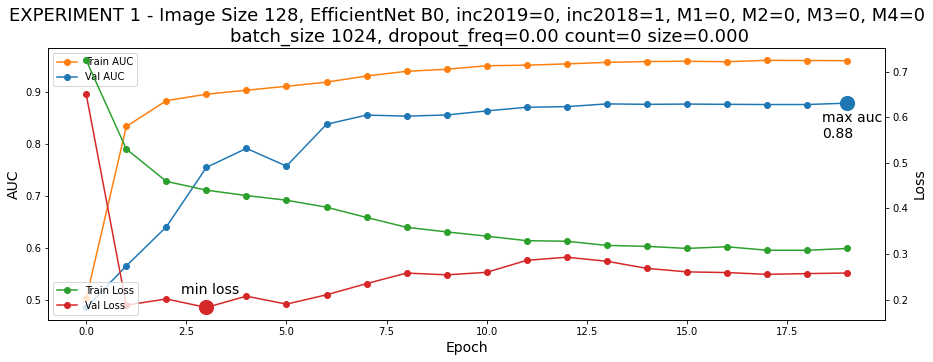

#########################
#### EXPERIMENT 2
#########################
#### Using the following TFRecords:
[ 0  1  2  4  5  6  7  8  9 10 13 14] [ 3 11 12]
#### Image Size 128 with EfficientNet B0 and batch_size 1024
#### DropoutFreq 0 Count0 Size 0
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Weight for class 0: 0.55
Weight for class 1: 5.39
Training...
Epoch 1/20
37/37 [==============================] - ETA: 0s - auc: 0.5850 - loss: 0.7062
Epoch 00001: val_loss improved from inf to 0.60046, saving model to EB0-128-fold-1-EXP.h5
37/37 [==============================] - 19s 503ms/step - auc: 0.5850 - loss: 0.7062 - val_auc: 0.4816 - val_loss: 0.6005 - lr: 5.0000e-06
Epoch 2/20
37/37 [==============================] - ETA: 0s - auc: 0.8285 - loss: 0.5298
Epoch 00002: val_loss improved from 0.60046 to 0.18493, saving model to EB0-128-fold-1-EXP.h5
37/37 [==============================] - 7s 

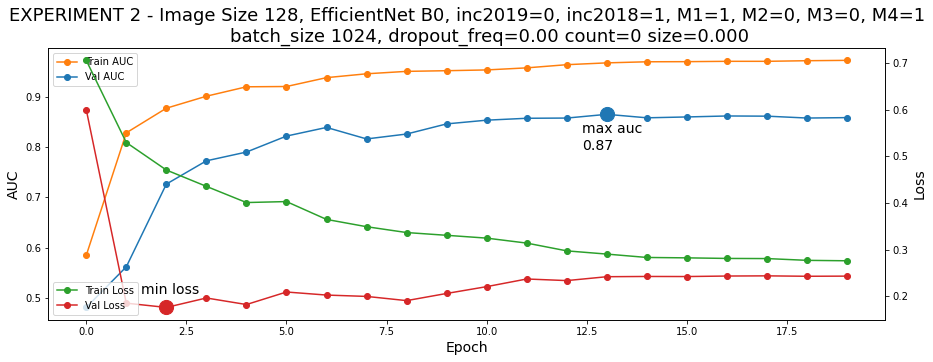

#########################
#### EXPERIMENT 3
#########################
#### Using the following TFRecords:
[ 0  1  2  4  5  6  7  8  9 10 13 14] [ 3 11 12]
#### Image Size 128 with EfficientNet B0 and batch_size 1024
#### DropoutFreq 0 Count0 Size 0
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Weight for class 0: 0.57
Weight for class 1: 4.00
Training...
Epoch 1/20
38/38 [==============================] - ETA: 0s - auc: 0.4804 - loss: 0.7706
Epoch 00001: val_loss improved from inf to 0.63512, saving model to EB0-128-fold-2-EXP.h5
38/38 [==============================] - 20s 517ms/step - auc: 0.4804 - loss: 0.7706 - val_auc: 0.4672 - val_loss: 0.6351 - lr: 5.0000e-06
Epoch 2/20
38/38 [==============================] - ETA: 0s - auc: 0.8159 - loss: 0.5454
Epoch 00002: val_loss improved from 0.63512 to 0.18413, s

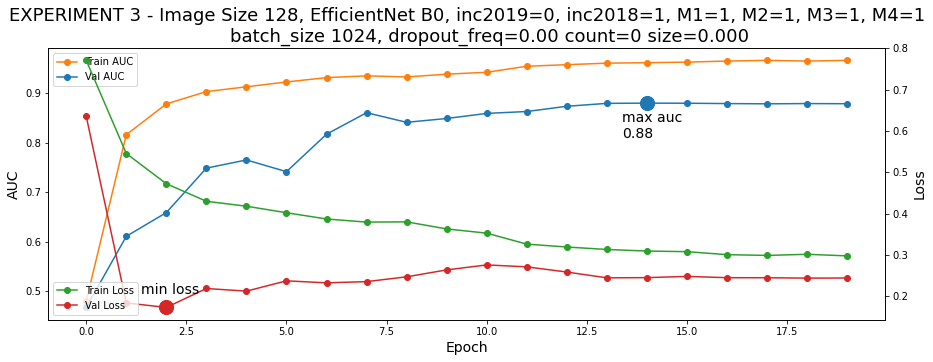

#########################
#### EXPERIMENT 4
#########################
#### Using the following TFRecords:
[ 0  1  2  4  5  6  7  8  9 10 13 14] [ 3 11 12]
#### Image Size 128 with EfficientNet B0 and batch_size 1024
#### DropoutFreq 0.5 Count4 Size 0.1
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Weight for class 0: 0.57
Weight for class 1: 4.00
Training...
Epoch 1/20
38/38 [==============================] - ETA: 0s - auc: 0.5347 - loss: 0.7285
Epoch 00001: val_loss improved from inf to 0.64727, saving model to EB0-128-fold-3-EXP.h5
38/38 [==============================] - 18s 474ms/step - auc: 0.5347 - loss: 0.7285 - val_auc: 0.6468 - val_loss: 0.6473 - lr: 5.0000e-06
Epoch 2/20
38/38 [==============================] - ETA: 0s - auc: 0.8380 - loss: 0.5260
Epoch 00002: val_loss improved from 0.64727 to 0.1770

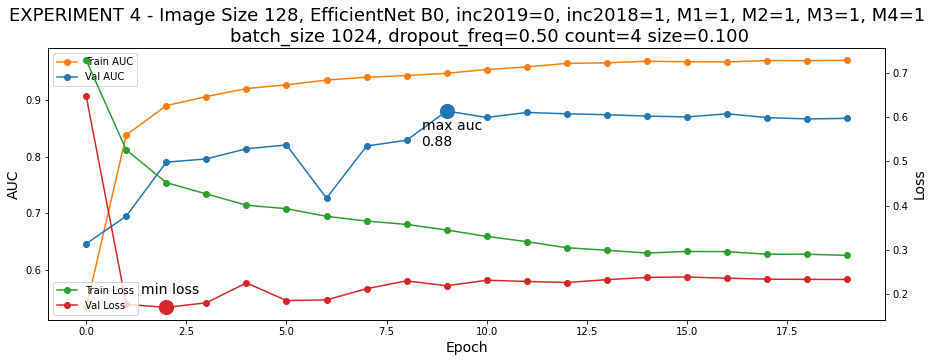

#########################
#### EXPERIMENT 5
#########################
#### Using the following TFRecords:
[ 0  1  2  4  5  6  7  8  9 10 13 14] [ 3 11 12]
#### Image Size 128 with EfficientNet B0 and batch_size 1024
#### DropoutFreq 0.75 Count8 Size 0.2
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Weight for class 0: 0.57
Weight for class 1: 4.00
Training...
Epoch 1/20
38/38 [==============================] - ETA: 0s - auc: 0.5852 - loss: 0.7084
Epoch 00001: val_loss improved from inf to 0.60674, saving model to EB0-128-fold-4-EXP.h5
38/38 [==============================] - 19s 499ms/step - auc: 0.5852 - loss: 0.7084 - val_auc: 0.6012 - val_loss: 0.6067 - lr: 5.0000e-06
Epoch 2/20
38/38 [==============================] - ETA: 0s - auc: 0.8341 - loss: 0.5315
Epoch 00002: val_loss improved from 0.60674 to 0.219

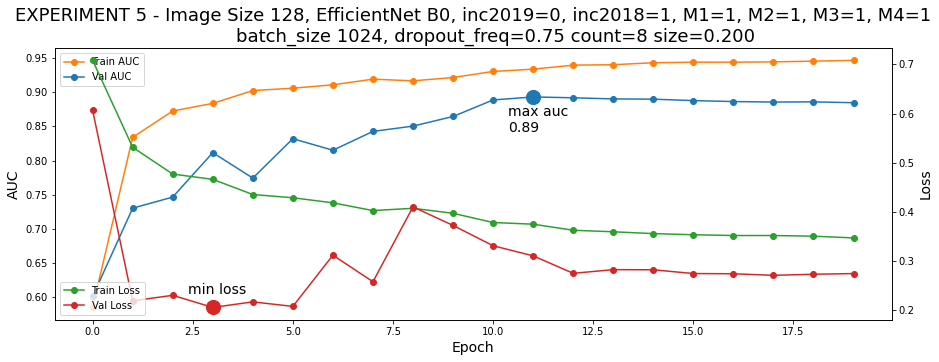

In [20]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

oof_pred = []
oof_tar = []
oof_val = []
oof_names = []
oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))
preds_meta_ls = np.zeros((count_data_items(files_test),1))

best_val_auc_ls = []
best_epoch_val_auc_ls = []

best_val_loss_ls = []
best_epoch_val_loss_ls = []

best_meta_wgts = []

#TESTING ONLY
loops = 0
max_loops = EXPERIMENTS #Use EXPERIMENTS or a number less than FOLDS if testing

for fold in range(EXPERIMENTS):
    # REPEAT SAME FOLD OVER AND OVER
    idxT = idxTT
    idxV = idxVV
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25)
    print('#### EXPERIMENT',fold+1)
    print('#'*25)
    print('#### Using the following TFRecords:')
    print(idxT,idxV)
    print(f'#### Image Size {IMG_SIZES[fold]} with EfficientNet B{EFF_NETS[fold]} and batch_size {BATCH_SIZES[fold]*REPLICAS}')
    print(f'#### DropoutFreq {DROP_FREQ[fold]} Count{DROP_CT[fold]} Size {DROP_SIZE[fold]}')
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    for k in range(M1[fold]):
        files_train += tf.io.gfile.glob([PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT])
        print('#### Upsample MALIG-1 data (2020 comp)')
    for k in range(M2[fold]):
        files_train += tf.io.gfile.glob([PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT+15])
        print('#### Upsample MALIG-2 data (ISIC website)')
    for k in range(M3[fold]):
        files_train += tf.io.gfile.glob([PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
        print('#### Upsample MALIG-3 data (2019 comp)')
    for k in range(M4[fold]):
        files_train += tf.io.gfile.glob([PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+30])
        print('#### Upsample MALIG-4 data (2018 2017 comp)')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(PATH[fold] + '/test*.tfrec')))
    
    # DETERMINE CLASS WEIGHTS FROM TRAINING DATASET
    # Analyze class imbalance in the targets
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    ft = get_dataset(files_train, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    ott = np.array([target.numpy() for img, target in iter(ft.unbatch())])
    tot = len(ott)
    counts = np.bincount(ott[:])
    
    weight_for_0 = (1 / counts[0])*(tot)/2.0 
    weight_for_1 = (1 / counts[1])*(tot)/2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold],v=0)
        
    # CALLBACKS - SAVE BEST MODEL EACH FOLD ALSO UTILISE EARLY STOPPING TO ALLOW MORE EPOCHS
    sv = tf.keras.callbacks.ModelCheckpoint(
        f'{CV_FOLDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-fold-{fold}-EXP.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    if EARLY_STOPPING:
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=VERBOSE, mode='min')
        callback_list = [sv,es,get_lr_callback(TS_CFG, BATCH_SIZES[fold])]
    else:
        callback_list = [sv,get_lr_callback(TS_CFG, BATCH_SIZES[fold])]
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                    dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold],
                    droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold]), 
        epochs=EPOCHS[fold],
        callbacks = callback_list, 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                        repeat=False,dim=IMG_SIZES[fold]),
        class_weight = class_weight,
        verbose=VERBOSE
    )
    
    # DETERMINE BEST SCORES AND EPOCHS
    val_auc_ls = history.history['val_auc']
    val_loss_ls = history.history['val_loss']
    
    best_val_auc = max(val_auc_ls)
    best_val_loss = min(val_loss_ls)
    best_val_auc_ls.append(best_val_auc)
    best_val_loss_ls.append(best_val_loss)
    
    opt_epoch_auc = val_auc_ls.index(best_val_auc)
    opt_epoch_loss = val_loss_ls.index(best_val_loss)
    best_epoch_val_auc_ls.append(opt_epoch_auc)
    best_epoch_val_loss_ls.append(opt_epoch_loss)
    
    #RELOAD BEST WEIGHTS AT BEST EPOCH
    print('Loading best model...')
    model.load_weights(f'{CV_FOLDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-fold-{fold}-EXP.h5')
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
                          repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
                          droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # INCLUDING ENSEMBLE OF META DATA
    meta_wgt_auc = []

    dsp_ft = get_meta(files_train)
    dsp_fv = get_meta(files_valid)
    meta_train = meta_unbatch(dsp_ft)
    meta_val = meta_unbatch(dsp_fv)
    meta_pred = meta_model(meta_train, meta_val)
    meta_pred['oof'] = oof_pred[-1]
    meta_auc = roc_auc_score(meta_pred['target'],meta_pred['ll'])    

    for wgt in range(0, 31, 1):
        wgt = wgt/100
        meta_pred['ens'] = ((1-wgt)*meta_pred.oof + wgt*meta_pred.ll)
        meta_auc = roc_auc_score(meta_pred['target'],meta_pred['ll'])
        meta_ens_auc = roc_auc_score(meta_pred['target'],meta_pred['ens'])    
        meta_wgt_auc.append([wgt, meta_ens_auc])
        #print(f"With Meta Weight {wgt}, Meta and OOF AUC with TTA:", meta_ens_auc)
    best_meta_wgts.append(max(meta_wgt_auc, key=lambda item: item[1]))    
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
                         repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4,
                         droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,]
    pred = np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1)
    preds[:,0] += pred * WGTS[fold]
    
    dsp_test = get_meta(files_test, BATCH_SIZES[0], test=1)
    meta_test = meta_unbatch(dsp_test, test=1)
    meta_test = meta_model(meta_train, meta_test)
    meta_test['preds'] = pred
    meta_test['preds_meta'] = best_meta_wgts[-1][0]*meta_test.ll + (1-best_meta_wgts[-1][0])*meta_test.preds
    preds_meta = np.array([meta_test.preds_meta]).T
    preds_meta_ls += preds_meta * WGTS[fold]

    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print(f'#### FOLD {fold+1} OOF AUC without TTA = {oof_val[-1]:.3f}, with TTA = {auc:.3f}')
    print("Meta only AUC:", meta_auc) 
    print(f"The best weight is {best_meta_wgts[-1][0]}, Meta and OOF AUC with TTA: {best_meta_wgts[-1][1]:.3f}")
    
    COMPLETED_EPOCHS = len(history.history['loss'])
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] )
        y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4')
        plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] )
        y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728')
        plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('EXPERIMENT %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i, M1=%i, M2=%i, M3=%i, M4=%i\n\
        batch_size %i, dropout_freq=%.2f count=%i size=%.3f'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold],M1[fold],M2[fold],M3[fold],
                 M4[fold],BATCH_SIZES[fold]*REPLICAS,DROP_FREQ[fold],DROP_CT[fold],DROP_SIZE[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  
        
        # TESTING ONLY
        loops+=1
        if loops == max_loops:
            break
        else:
            continue
        
        del model; z = gc.collect()

#### Show the optimal characteristics from CV

In [21]:
best_epoch_val_auc_mean = np.mean(np.array(best_epoch_val_auc_ls), axis=0)
best_epoch_val_loss_mean = np.mean(np.array(best_epoch_val_loss_ls), axis=0)

print("The best epoch value for AUC over the cv is: ",best_epoch_val_auc_mean)
print("The best epoch value for loss over the cv is: ",best_epoch_val_loss_mean)

The best epoch value for AUC over the cv is:  13.2
The best epoch value for loss over the cv is:  2.4


In [22]:
cv_val_auc_mean = np.mean(np.array(best_val_auc_ls), axis=0)
cv_val_auc_std = np.std(np.array(best_val_auc_ls), axis=0)
cv_val_loss_mean = np.mean(np.array(best_val_loss_ls), axis=0)

print(f"The mean AUC score across CV folds is {cv_val_auc_mean:.2f} and the standard deviation is {cv_val_auc_std:.2%}")

The mean AUC score across CV folds is 0.88 and the standard deviation is 0.88%


#### Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [23]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar);
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv(f'{CV_OOF_PREDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-oof-EXP.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.711


,image_name,target,pred,fold
0,ISIC_0077472,0,0.026139,0
1,ISIC_0074268,0,0.027372,0
2,ISIC_0080512,0,0.005496,0
3,ISIC_0080752,0,0.015131,0
4,ISIC_0075663,0,0.062672,0


#### Calculate OOF AUC with Tabular Data
Utilising a simple prediction model on the tabular data should add additional information when blending. This can be tested with the OOF data.

In [24]:
best_wgt = []
best_auc = []
for best in best_meta_wgts:
    best_wgt.append(best[0])
    best_auc.append(best[1])
avg_wgt = sum(best_wgt)/len(best_wgt)
avg_auc = sum(best_auc)/len(best_auc)
print(f"Average of best meta weights = {avg_wgt:.2f}")
print(f"Overall OOF and Meta AUC with TTA = {avg_auc:.3f}")

Average of best meta weights = 0.19
Overall OOF and Meta AUC with TTA = 0.797


### Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

### Log values from the cross validation process

In [25]:
if ENV == 'LOCAL':
    log_df = pd.read_csv('./logs/experiment_log.csv')
    headers = list(log_df.columns.values)
    
if ENV == 'KAGGLE':
    headers = ['Image Size',
             'Model',
             '2018 Data',
             'Batch Size',
             'Replicas',
             'Total Batch Size',
             'TTA Loops',
             'CV Folds',
             'Mean CV AUC',
             'Std CV AUC',
             'OOF AUC with TTA',
             'OOF AUC and Meta with TTA',
             'Best average Meta weighting',
             'Mean CV Loss',
             'Total Epochs',
             'Early Stop',
             'Best AUC Epoch',
             'Best Loss Epoch',
             'Kaggle LB AUC',
             'Kaggle LB AUC w Meta']
    log_df = pd.DataFrame(columns = headers)

In [26]:
log_items = [IMG_SIZES[0],
            str(f"EFNB{EFF_NETS[0]}EXP"),
            INC2018[0],
            BATCH_SIZES[0],
            REPLICAS,
            BATCH_SIZES[0] * REPLICAS,
            TTA,
            FOLDS,
            cv_val_auc_mean,
            cv_val_auc_std, 
            auc,
            avg_auc,
            avg_wgt,
            cv_val_loss_mean,
            EPOCHS[0],
            EARLY_STOPPING,
            best_epoch_val_auc_mean,
            best_epoch_val_loss_mean,
            0.00,
            0.00]

In [27]:
for n in range(len(headers)):
    print(headers[n]+":", log_items[n])
    
log_data = pd.DataFrame([log_items], columns=headers)
log_df = log_df.append(log_data)
log_df.sort_values(by=['Model','Image Size'], inplace=True)
log_df.to_csv(f'{LOG_PATH}experiment_log.csv', index=False)
log_df.head(30)

Image Size: 128
Model: EFNB0EXP
2018 Data: 1
Batch Size: 128
Replicas: 8
Total Batch Size: 1024
TTA Loops: 25
CV Folds: 5
Mean CV AUC: 0.8793660044670105
Std CV AUC: 0.008844053834424511
OOF AUC with TTA: 0.7111907056091743
OOF AUC and Meta with TTA: 0.7973331016580578
Best average Meta weighting: 0.18600000000000003
Mean CV Loss: 0.18148947954177858
Total Epochs: 20
Early Stop: 0
Best AUC Epoch: 13.2
Best Loss Epoch: 2.4
Kaggle LB AUC: 0.0
Kaggle LB AUC w Meta: 0.0


,Image Size,Model,2018 Data,Batch Size,Replicas,Total Batch Size,TTA Loops,CV Folds,Mean CV AUC,Std CV AUC,OOF AUC with TTA,OOF AUC and Meta with TTA,Best average Meta weighting,Mean CV Loss,Total Epochs,Early Stop,Best AUC Epoch,Best Loss Epoch,Kaggle LB AUC,Kaggle LB AUC w Meta
0,128,EFNB0EXP,1,128,8,1024,25,5,0.879366,0.008844,0.711191,0.797333,0.186,0.181489,20,0,13.2,2.4,0.0,0.0


### Prepare Kaggle File

In [28]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [29]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(f'{CV_TEST_PREDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-{FOLDS}F-EXP-submission.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.028018
1443,ISIC_0052349,0.038523
3120,ISIC_0058510,0.060529
4870,ISIC_0073313,0.033630
5494,ISIC_0073502,0.070580


In [30]:
submission_meta = pd.DataFrame(dict(image_name=image_names, target=preds_meta_ls[:,0]))
submission_meta = submission_meta.sort_values('image_name') 
submission_meta.to_csv(f'{CV_TEST_PREDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-{FOLDS}F-EXP-META-submission.csv', index=False)
submission_meta.head()

,image_name,target
9905,ISIC_0052060,0.058350
1443,ISIC_0052349,0.035230
3120,ISIC_0058510,0.059656
4870,ISIC_0073313,0.037475
5494,ISIC_0073502,0.069101


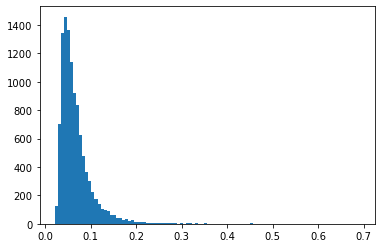

In [31]:
plt.hist(submission.target,bins=100)
plt.show()

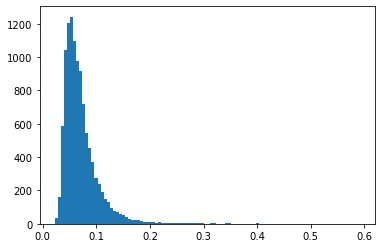

In [32]:
plt.hist(submission_meta.target,bins=100)
plt.show()